# Video Games Review: Analysis

In this project, I explore [Metacritic's video games reviews](https://www.metacritic.com/browse/games/score/metascore/all/all/filtered?page=0).


## Setup

In this section, I import all necessary libraries, setup the SQLite database, and then import the input `.csv` files in a format that allows manipulation by both `sqlite` and `pandas`:


In [47]:
import pandas as pd
from sqlalchemy import create_engine

sql_engine = create_engine("sqlite://", echo=False)
games_df = pd.read_csv("./input/games.csv")


In [48]:
def df_to_sql_table(sql_table_name: str, dataframe: pd.DataFrame) -> None:
    dataframe.to_sql(sql_table_name, sql_engine, if_exists="replace", index=False)
    print(
        f"""SQL table "{sql_table_name}" created/updated!

Please see below for a preview:"""
    )
    preview_sql_table(sql_table_name, sql_engine_name=sql_engine)


def preview_sql_table(
    sql_table_name: str,
    sql_engine_name,
    row_count=3,
) -> None:
    preview_sql_query = f"""SELECT * FROM {sql_table_name} LIMIT {row_count}"""
    display(pd.read_sql_query(preview_sql_query, sql_engine_name))


df_to_sql_table("games", games_df)


SQL table "games" created/updated!

Please see below for a preview:


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,"February 10, 2022",The year is 2119. A turning point has begun in...,tbd,tbd
1,! That Bastard Is Trying To Steal Our Gold !,PC,"May 11, 2014",It's a fun puzzle game where you need to steal...,tbd,3.4
2,!4RC4N01D!,PC,"January 12, 2018",Hardcore arkanoid in the spirit of old games f...,tbd,4.0


## Cleaning


### Missing Values


#### `tbd` Metascore and user score are missing values

Metascore will be `tbd` if there are <4 reviews for that game. User score will be "tbd" if there are <7 reviews for that game.


In [49]:
import numpy as np

score_columns = [sc for sc in games_df.columns if sc.endswith("score")]
for c in score_columns:
    games_df[c] = games_df[c].replace("tbd", np.NaN)

df_to_sql_table("games", games_df)


SQL table "games" created/updated!

Please see below for a preview:


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,"February 10, 2022",The year is 2119. A turning point has begun in...,None,None
1,! That Bastard Is Trying To Steal Our Gold !,PC,"May 11, 2014",It's a fun puzzle game where you need to steal...,None,3.4
2,!4RC4N01D!,PC,"January 12, 2018",Hardcore arkanoid in the spirit of old games f...,None,4.0


#### `summary`, `metascore` and `userscore` are difficult to impute

They are ignored for now, and will not be considered in analyses.


In [50]:
def count_missing_values(sql_table_name: str, col: str):
    count_missing_values_query = f"""
        SELECT SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) missing_values_count
        FROM {sql_table_name}
    """

    missing_count_df = pd.read_sql_query(count_missing_values_query, sql_engine)
    number_of_missing_values = int(missing_count_df.missing_values_count.iloc[0])
    print(f"""The column "{col}" has _{number_of_missing_values}_ missing values.""")
    if number_of_missing_values:
        show_missing_values_query = f"""
            SELECT *
            FROM {sql_table_name}
            WHERE {col} IS NULL
        """
        missing_values_df = pd.read_sql_query(show_missing_values_query, sql_engine)
        display(missing_values_df)
        return
    return


for c in games_df.columns:
    count_missing_values("games", c)


The column "name" has _0_ missing values.
The column "platform" has _0_ missing values.
The column "release_date" has _0_ missing values.
The column "summary" has _17715_ missing values.


,name,platform,release_date,summary,metascore,userscore
0,100 Great Education Games Volume 4,PC,"May 10, 2002",None,None,None
1,1001 Jigsaw Cute Cats,PC,"August 3, 2022",None,None,None
2,1010! World,iOS,"July 6, 2015",None,None,None
3,18 Wheels of Steel: Hard Truck,PC,"March 18, 2021",None,None,None
4,1912 Titanic Mystery,PC,"July 17, 2019",None,None,5.3
...,...,...,...,...,...,...
17710,without Kungfu shut up,PC,"November 29, 2018",None,None,None
17711,work girl,PC,"November 22, 2019",None,None,None
17712,world of cubes,PC,"June 27, 2022",None,None,None
17713,xdding,PC,"December 23, 2022",None,None,None


The column "metascore" has _112155_ missing values.


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,"February 10, 2022",The year is 2119. A turning point has begun in...,None,None
1,! That Bastard Is Trying To Steal Our Gold !,PC,"May 11, 2014",It's a fun puzzle game where you need to steal...,None,3.4
2,!4RC4N01D!,PC,"January 12, 2018",Hardcore arkanoid in the spirit of old games f...,None,4.0
3,!4RC4N01D! 2: Retro Edition,PC,"February 6, 2018","Everyone dreams of returning 2007, but no one ...",None,3.8
4,!4RC4N01D! 3: Cold Space,PC,"March 8, 2018",!4RC4N01D! returns! This time we have an accid...,None,3.0
...,...,...,...,...,...,...
112150,{Undefined},PC,"August 20, 2021","A sandbox survival game, set on life-sized vox...",None,None
112151,~ Daydream ~,PC,"May 26, 2022",~Daydream~is an action 2D platform jumping gam...,None,None
112152,~Azur Ring~virgin and slave's phylacteries,PC,"July 17, 2020",New DIABLO-Like adventure game. Legendary gear...,None,None
112153,~Gigantify~,PC,"January 23, 2022",This is a small Puzzle Platformer where you dy...,None,None


The column "userscore" has _105986_ missing values.


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,"February 10, 2022",The year is 2119. A turning point has begun in...,None,None
1,!Arre Unicornio!,PC,"March 18, 2022",Arre Unicornio! is an online multiplayer video...,None,None
2,"""Aha! I Found It!"" Hidden Object Game",Wii,"January 25, 2010",[WiiWare] A hidden-object game for everyone h...,None,None
3,"""Aha! I Got It!"" Escape Game",Wii,"November 2, 2009",[WiiWare] Play alone or with family and frien...,None,None
4,"""Burn your fat with me!!""",iOS,"September 25, 2012",“Burn your fat with me!!” is a fitness app/dat...,None,None
...,...,...,...,...,...,...
105981,{Undefined},PC,"August 20, 2021","A sandbox survival game, set on life-sized vox...",None,None
105982,~ Daydream ~,PC,"May 26, 2022",~Daydream~is an action 2D platform jumping gam...,None,None
105983,~Azur Ring~virgin and slave's phylacteries,PC,"July 17, 2020",New DIABLO-Like adventure game. Legendary gear...,None,None
105984,~Gigantify~,PC,"January 23, 2022",This is a small Puzzle Platformer where you dy...,None,None


### Correct Data Types


In [64]:
for c in score_columns:
    games_df[c] = pd.to_numeric(games_df[c])

games_df["release_date"] = pd.to_datetime(games_df["release_date"], format="%B %d, %Y")
games_df["release_date"] = games_df["release_date"].dt.strftime("%Y-%m-%d")

df_to_sql_table("games", games_df)


SQL table "games" created/updated!

Please see below for a preview:


,name,platform,release_date,summary,metascore,userscore
0,! SPACE ACCIDENT !,PC,2022-02-10,The year is 2119. A turning point has begun in...,None,NaN
1,! That Bastard Is Trying To Steal Our Gold !,PC,2014-05-11,It's a fun puzzle game where you need to steal...,None,3.4
2,!4RC4N01D!,PC,2018-01-12,Hardcore arkanoid in the spirit of old games f...,None,4.0


## Analysis


### Metascore vs User Scores

There are up to two scores (assuming sufficient rating volumes) for each game:

- A game's **Metascore** is the [weighted average of critics' and publications' reviews](https://www.metacritic.com/about-metascores).
- A game's **user score** is the mean of users' scores.


#### Metascores and user scores have a **_low_**, **_positive_** correlation

The Pearson Correlation Coefficient is approx `+0.270`.

Unlike other SQL implementations (like PostgreSQL's `CORR()`), SQLite lacks built-in function to calculate the correlation coefficient. Thus, I implement the calculation manually using the formula:

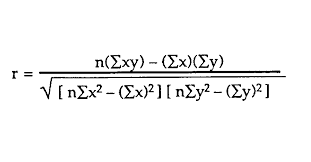


In [65]:
pd.read_sql_query(
    """
    SELECT AVG( (userscore - avg_userscore) * (metascore - avg_metascore) ) * AVG( (userscore - avg_userscore) * (metascore - avg_metascore) ) / (var_userscore * var_metascore) AS pearson_corr_coeff 
    FROM games,
        (
            SELECT avg_userscore,
                avg_metascore,
                AVG((userscore - avg_userscore)*(userscore - avg_userscore)) as var_userscore,
                AVG((metascore - avg_metascore)*(metascore - avg_metascore)) as var_metascore
            FROM games,
                (
                    SELECT AVG(userscore) AS avg_userscore,
                        AVG(metascore) AS avg_metascore
                    FROM games
                )
        )
    """,
    sql_engine,
)


,pearson_corr_coeff
0,0.215795


Visually, a scatterplot of all games' user score (x-axis) against Metascore (y-axis) validates this positive correlation.


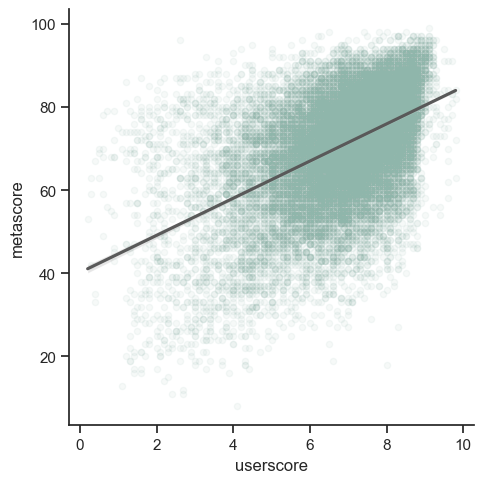

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.lmplot(
    data=games_df,
    x="userscore",
    y="metascore",
    scatter_kws={"color": "#8fb6ab", "alpha": 0.08, "s": 20},
    line_kws={"color": "#595959"},
)
plt.show()


### Platforms


#### **Nintendo 64** and **PlayStation** have the highest rated games


In [54]:
# transforming table to allow split boxplots
# normalise metascore by having it out of 10 instead of 100

scores_stacked_df = pd.read_sql_query(
    """
    SELECT name,
        platform,
        metascore / 10 score, 
        'meta' score_type,
        STRFTIME('%Y-%m-%d', release_date) release_date
    FROM games
    WHERE score NOT NULL
    UNION ALL
    SELECT name,
        platform,
        userscore score,
        'user' score_type,
        STRFTIME('%Y-%m-%d', release_date) release_date
    FROM games
    WHERE score NOT NULL
""",
    sql_engine,
)
scores_stacked_df.head(3)


,name,platform,score,score_type,release_date
0,"""klocki""",iOS,8.3,meta,2016-07-13
1,#DRIVE,Switch,6.9,meta,2021-02-16
2,#IDARB,Xbox One,7.7,meta,2015-01-30


As SQLite does not have a built-in function nor efficient alternative to query the median values of each platform, we use `pandas`' `.median()` method:


In [55]:
median_scores_df = (
    scores_stacked_df.groupby(["platform", "score_type"])
    .score.median()
    .reset_index()
    .rename(columns={"score": "median_score"})
)
median_scores_df.head(3)


,platform,score_type,median_score
0,3DS,meta,6.9
1,3DS,user,7.2
2,DS,meta,6.6


With the exception of Nintendo DS and Nintendo Wii, Metascores' distribution for each platform is similar to one another.

**Nintendo DS** and **Nintendo Wii** have lower, median and interquartile ranges of _Metascores_, though _users_ have reviewed games of other platforms lower.

Overall, the higher number of outliers for _user_ scores (as compared to Metascores) imply users tend to disagree with one another more than critics, which is expected. In particular, **PC** games have noticeably more low-end outliers, especially for user scores <4.


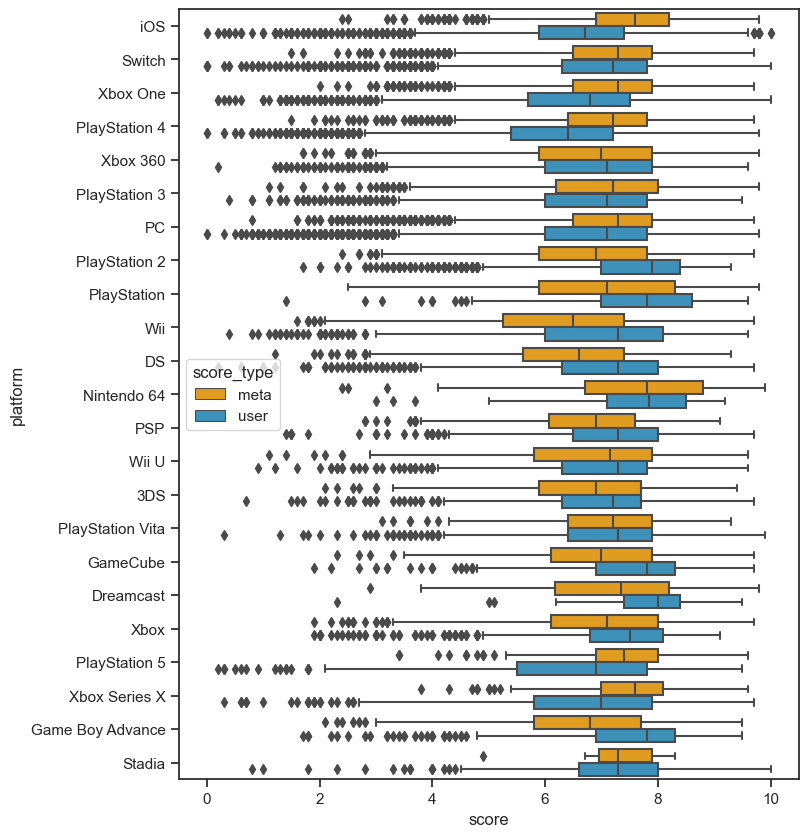

In [56]:
plt.figure(figsize=(8, 10))
bp = sns.boxplot(
    data=scores_stacked_df,
    x="score",
    y="platform",
    hue="score_type",
    orient="h",
    palette=["orange", "#2998cd"],
)
plt.show()


#### Overall, users agree that **_handheld_** games are better

- Across all platform types, Metascores vary far more between games than user scores.
- Overall, users tend to rate **_handheld_** games the highest, followed by "hybrid" games (which refers to the Nintendo Switch, which can be played both as a _handheld_ platform and a home console).
- _iOS_ games have the lowest median user scores, albeit only slightly compared to the other categories


In [57]:
platform_type_df = pd.read_sql_query(
    """
    SELECT *,
        CASE
            WHEN platform IN ('3DS', 'DS', 'Game Boy Advance', 'PSP', 'PlayStation Vita') THEN 'handheld'
            WHEN platform IS 'Switch' THEN 'hybrid'
            WHEN platform IS 'PC' THEN 'pc'
            WHEN platform IS 'iOS' THEN 'mobile'
            ELSE 'home console'
        END platform_type
    FROM games
    """,
    sql_engine,
)
platform_type_df.head(3)


,name,platform,release_date,summary,metascore,userscore,platform_type
0,! SPACE ACCIDENT !,PC,2022-02-10 00:00:00.000000,The year is 2119. A turning point has begun in...,NaN,NaN,pc
1,! That Bastard Is Trying To Steal Our Gold !,PC,2014-05-11 00:00:00.000000,It's a fun puzzle game where you need to steal...,NaN,3.4,pc
2,!4RC4N01D!,PC,2018-01-12 00:00:00.000000,Hardcore arkanoid in the spirit of old games f...,NaN,4.0,pc


In [58]:
df_to_sql_table("scores_unpivoted", scores_stacked_df)


SQL table "scores_unpivoted" created/updated!

Please see below for a preview:


,name,platform,score,score_type,release_date
0,"""klocki""",iOS,8.3,meta,2016-07-13
1,#DRIVE,Switch,6.9,meta,2021-02-16
2,#IDARB,Xbox One,7.7,meta,2015-01-30


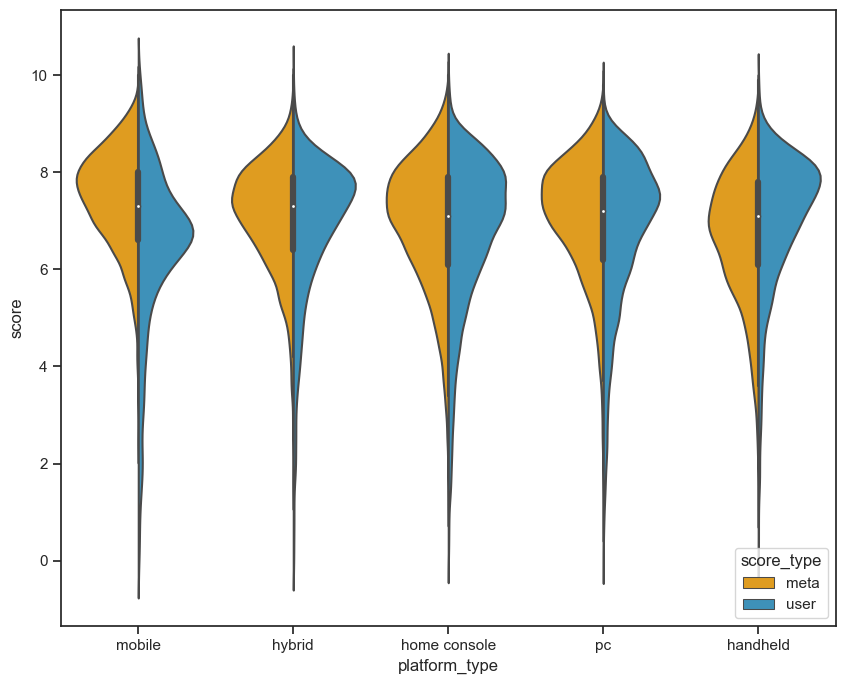

In [59]:
# transforming table in preparation for split boxplot
scores_unpivoted_platform_cats = pd.read_sql_query(
    """
    SELECT *,
        CASE
            WHEN platform IN ('3DS', 'DS', 'Game Boy Advance', 'PSP', 'PlayStation Vita') THEN 'handheld'
            WHEN platform IS 'Switch' THEN 'hybrid'
            WHEN platform IS 'PC' THEN 'pc'
            WHEN platform IS 'iOS' THEN 'mobile'
            ELSE 'home console'
        END platform_type
    FROM scores_unpivoted
    """,
    sql_engine,
)

plt.figure(figsize=(10, 8))
sns.violinplot(
    data=scores_unpivoted_platform_cats,
    x="platform_type",
    y="score",
    hue="score_type",
    palette=["orange", "#2998cd"],
    split=True,
)
plt.show()


### Games released in the **_late 90s_** tend to have higher user scores and Metascores...

-- NEED TO CHANGE --

Which aligns with our findings above that N64 (released 1996) and PS1 (released 1994) had the highest rated games

- As time goes by, newer-released games tend to attract _lower_ user scores (although there are exceptions, in the form of outliers)
- Games released in 2006-2008 inclusive attracted poorer Metascores


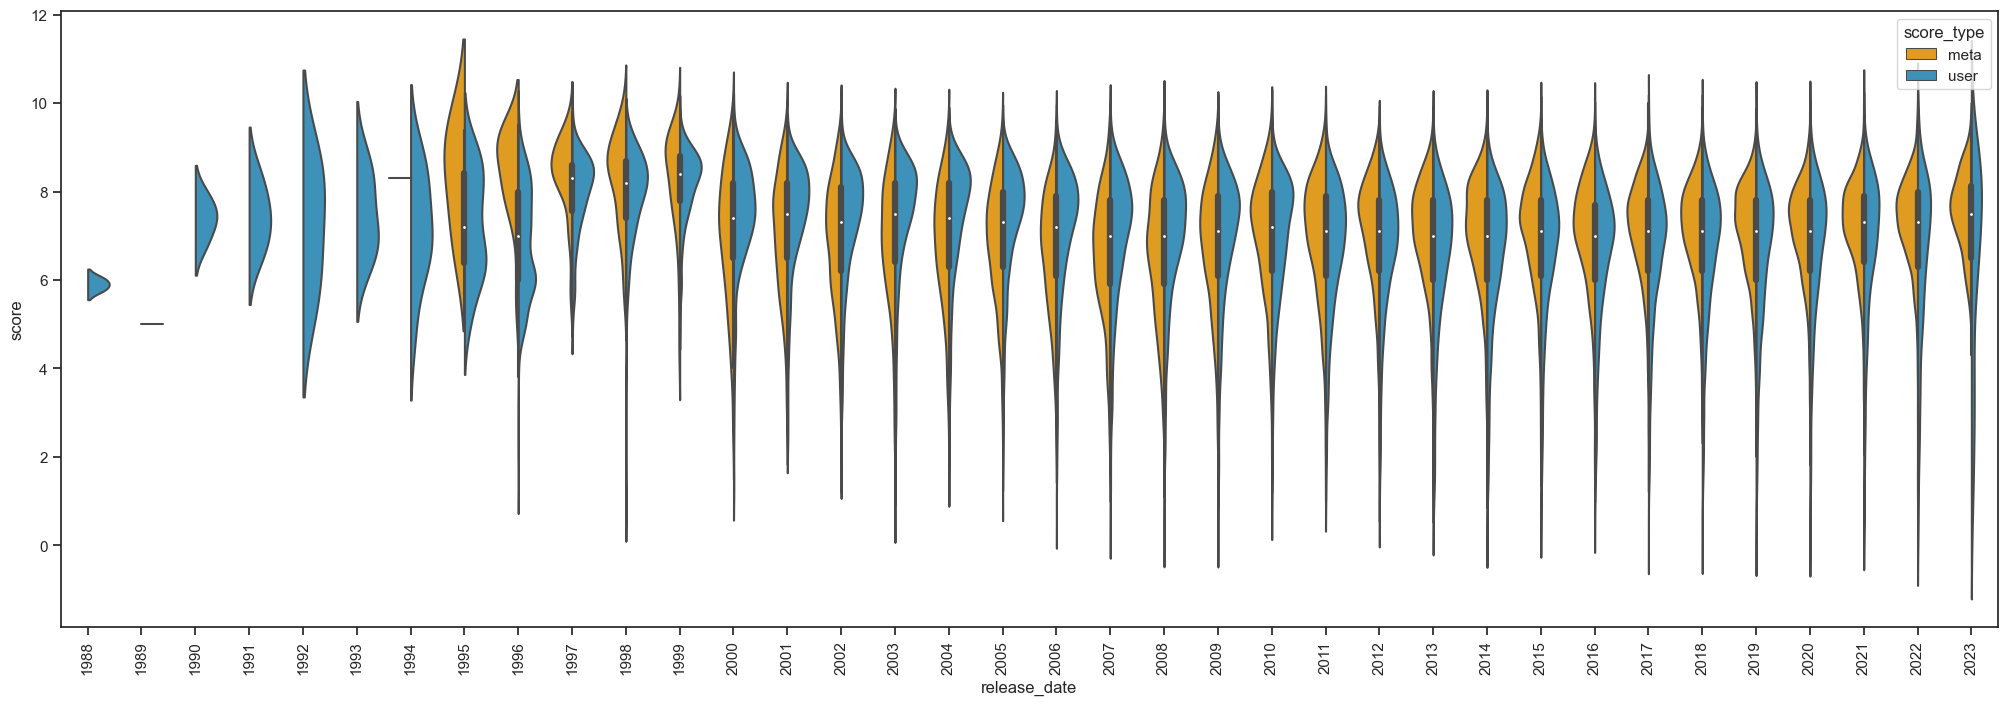

In [60]:
scores_stacked_df["release_date"] = pd.to_datetime(
    scores_stacked_df.release_date, format="%Y-%m-%d"
)

plt.figure(figsize=(25, 8))
sns.violinplot(
    data=scores_stacked_df,
    x=scores_stacked_df.release_date.dt.year,
    y="score",
    hue="score_type",
    split=True,
    palette=["orange", "#2998cd"],
)
plt.xticks(rotation=90)
plt.show()


Median scores (which are less sensitive to outliers compared to mean) confirm these findings:

1. Median user scores decline as the game is released more recently, reaching a historical low for games released in 2023
2. Median Metascores have stayed around `7.0` following a dip for games released 2006-2008 inclusive.


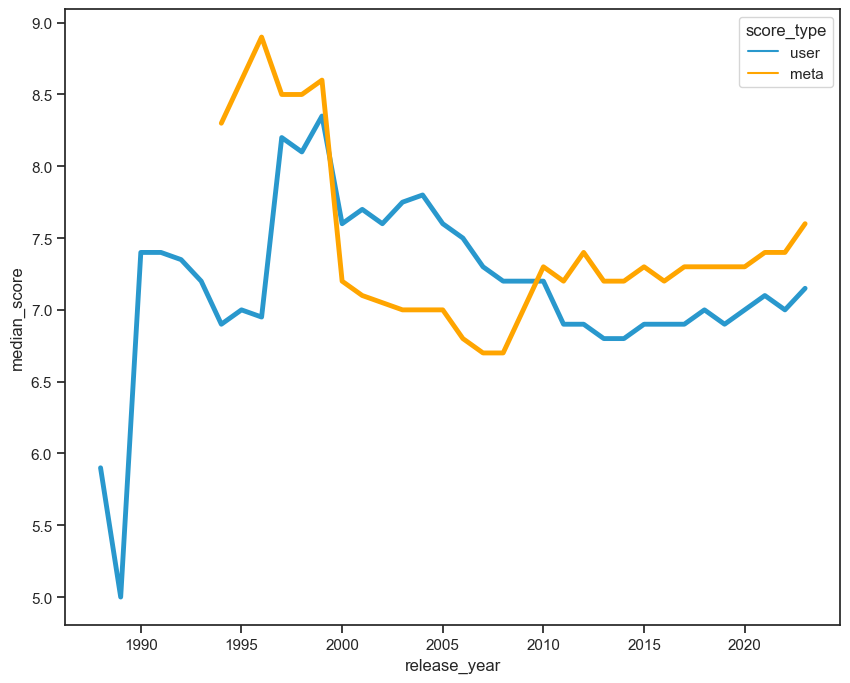

In [61]:
scores_stacked_by_year = scores_stacked_df.copy().drop("platform", axis=1)
scores_stacked_by_year["release_date"] = pd.to_datetime(
    scores_stacked_by_year.release_date, format="%Y-%m-%d"
)
scores_stacked_by_year["release_year"] = scores_stacked_by_year.release_date.dt.year
median_scores_by_year = (
    scores_stacked_by_year.groupby(["release_year", "score_type"])
    .score.median()
    .reset_index()
    .rename(columns={"score": "median_score"})
)
# median_scores_by_year.head(5)

plt.figure(figsize=(10, 8))
sns.lineplot(
    data=median_scores_by_year,
    x="release_year",
    y="median_score",
    hue="score_type",
    palette=["#2998cd", "orange"],
    linewidth=3.5,
)
plt.show()


In [62]:
scores_stacked_by_year


,name,score,score_type,release_date,release_year
0,"""klocki""",8.3,meta,2016-07-13,2016
1,#DRIVE,6.9,meta,2021-02-16,2021
2,#IDARB,7.7,meta,2015-01-30,2015
3,#KILLALLZOMBIES,5.3,meta,2016-08-10,2016
4,#KILLALLZOMBIES,6.3,meta,2014-10-28,2014
...,...,...,...,...,...
66688,void tRrLM(); //Void Terrarium,7.0,user,2020-07-14,2020
66689,void tRrLM();++ //Void Terrarium++,6.6,user,2021-05-18,2021
66690,while True: learn,6.2,user,2019-01-17,2019
66691,xXx,5.0,user,2002-07-31,2002


In [63]:
games_df.sort_values("release_date", ascending=True)


,name,platform,release_date,summary,metascore,userscore
112299,Starflight,PC,1986-08-15,An alien mystery darkens the galaxy! Command a...,NaN,NaN
67493,Leisure Suit Larry Goes Looking for Love (In S...,PC,1988-10-27,Who is Leisure Suit Larry?\r\nIf you look up t...,NaN,6.0
50778,Gold Rush!,PC,1988-12-22,"The gold rush is on! Sell your land, pack your...",NaN,5.8
67494,Leisure Suit Larry III: Passionate Patti in Pu...,PC,1989-04-09,"Are you a smooth, suave, single guy on the mak...",NaN,5.0
116462,Sword of the Samurai,PC,1989-11-03,"In Sword of the Samurai, you will be part of t...",NaN,NaN
...,...,...,...,...,...,...
77002,Monster Energy Supercross - The Official Video...,Xbox Series X,2023-03-09,"Mud, sweat, fun and adrenaline: find the rider...",NaN,NaN
77003,Monster Energy Supercross - The Official Video...,PlayStation 5,2023-03-09,"Mud, sweat, fun and adrenaline: find the rider...",69.0,NaN
2203,AA Soldiers,PC,2023-03-09,This game is a simple 3D missile shooter. It's...,NaN,NaN
129463,Transport Fever 2: Console Edition,PlayStation 5,2023-03-09,The classic transport simulation genre has a n...,NaN,NaN
